In [2]:
pip install causalgraphicalmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from causalgraphicalmodels import StructuralCausalModel
from causalgraphicalmodels.csm import discrete_model, linear_model

from sklearn.linear_model import LinearRegression
import math
import itertools

# Continuous model

Generating the model

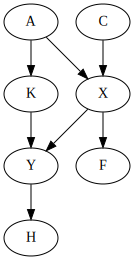

In [4]:
fd_cont = StructuralCausalModel({
    "C": lambda n_samples: np.random.uniform(low=-10, high=10,
                                             size=n_samples),
    "A": lambda n_samples: .8 * np.random.normal(size=n_samples),
    "K": lambda A, n_samples: A + .1 * np.random.normal(),
    "X": lambda C, A, n_samples: 0.7 * C - 2 * A + .2 * np.random.normal(),
    "F": lambda X, n_samples: 3 * X + .8 * np.random.normal(),
    "Y": lambda K, X, n_samples: 2 * K - X + .2 * np.random.normal(),
    "H": lambda Y, n_samples: .5 * Y + .1 * np.random.normal()
})

fd_cont.cgm.draw()

In [5]:
data_df = fd_cont.sample(n_samples=1000000)

In [6]:
data_df

,C,A,K,X,F,Y,H
0,4.150547,0.419426,0.595674,1.668816,6.006416,-0.613871,-0.325695
1,-5.455510,0.173018,0.349266,-4.562606,-12.687851,5.124734,2.543607
2,5.420101,-0.079091,0.097156,3.554540,11.663587,-3.496630,-1.767075
3,3.350267,-0.562903,-0.386655,3.073278,10.219802,-3.982991,-2.010255
4,-6.947862,-0.456422,-0.280174,-4.348373,-12.045151,3.651621,1.807051
...,...,...,...,...,...,...,...
999995,-2.671416,-0.142861,0.033386,-1.981982,-4.945978,1.912351,0.937416
999996,-8.709723,0.085268,0.261516,-6.665056,-18.995200,7.051685,3.507083
999997,9.125532,-0.225049,-0.048801,6.440256,20.320738,-6.674262,-3.355891
999998,7.771312,0.568122,0.744370,3.905961,12.717850,-2.553624,-1.295572


Excercise 1:

Implement backdoor adjustment for arbitrary treatment, effect and conditioning set using Linear Regression.

Check if your implementation is working correctly.

In [7]:
all_sets = [
            ['C'],
            ['A'],
            ['K'],
            ['F'],
            ['H'],
            ['C', 'A'],
            ['C', 'K'],
            ['C', 'F'],
            ['C', 'H'],
            ['A', 'K'],
            ['A', 'F'],
            ['A', 'H'],
            ['K', 'F'],
            ['K', 'H'],
            ['F', 'H'],
            ['C', 'A', 'K'],
            ['C', 'A', 'F'],
            ['C', 'A', 'H'],
            ['C', 'K', 'F'],
            ['C', 'K', 'H'],
            ['C', 'F', 'H'],
            ['A', 'K', 'F'],
            ['A', 'K', 'H'],
            ['K', 'F', 'H'],
            ['C', 'A', 'K', 'F'],
            ['C', 'A', 'K', 'H'],
            ['C', 'K', 'F', 'H'],
            ['A', 'K', 'F', 'H'],
            ['C', 'A', 'K', 'F', 'H']
            ]

In [8]:
def my_backdoor_adjustment_regression(data=data_df, T='X', Y='Y', cond_set = ['A', 'K'], true_ate=None):
    # add your implementation
    # conditioning set can be empty, can contain 1 or more variables.
    # conditioning set never contains T or Y
    regressor = LinearRegression()
    # Regressing Y on [T, cond_set]
    regressor.fit(data[list(T) + cond_set].values, data[Y].values)  
    # Reporting coefficient of T
    print(f"Set: {list(T) + cond_set}, X has the coefficient: {regressor.coef_[0]}")
    coeff_X = regressor.coef_[0]
    # Check if the estimation is close to the actual causal effect
    if math.isclose(coeff_X, true_ate, rel_tol=1e-2) == True:
      return True
    else:
      return False   
        

In [9]:
my_backdoor_adjustment_regression(data_df, T='X', Y='Y', cond_set=[], true_ate = -1)

Set: ['X'], X has the coefficient: -1.136049623583688


False

In [10]:
adj_sets = []
for var_set in all_sets:
  if my_backdoor_adjustment_regression(data_df, T='X', Y='Y', cond_set=var_set, true_ate = -1) == True:
    adj_sets.append(var_set)

Set: ['X', 'C'], X has the coefficient: -2.000000000000001
Set: ['X', 'A'], X has the coefficient: -1.000000000000001
Set: ['X', 'K'], X has the coefficient: -1.000000000000001
Set: ['X', 'F'], X has the coefficient: -0.11360496235836894
Set: ['X', 'H'], X has the coefficient: 5.168279271771585e-17
Set: ['X', 'C', 'A'], X has the coefficient: -1.5464480874316946
Set: ['X', 'C', 'K'], X has the coefficient: -1.5464480874316946
Set: ['X', 'C', 'F'], X has the coefficient: -2.8178953315559694
Set: ['X', 'C', 'H'], X has the coefficient: -0.9422850412249708
Set: ['X', 'A', 'K'], X has the coefficient: -1.0000000000000009
Set: ['X', 'A', 'F'], X has the coefficient: -1.8066016303328685
Set: ['X', 'A', 'H'], X has the coefficient: -0.44444444444444525
Set: ['X', 'K', 'F'], X has the coefficient: -1.8070488433125473
Set: ['X', 'K', 'H'], X has the coefficient: -0.44444444444444525
Set: ['X', 'F', 'H'], X has the coefficient: -0.4516180049237643
Set: ['X', 'C', 'A', 'K'], X has the coefficient

In [11]:
adj_sets

[['A'], ['K'], ['A', 'K']]

Valid adjustments sets:

In [12]:
fd_cont.cgm.get_all_backdoor_adjustment_sets(x='X', y='Y')

frozenset({frozenset({'K'}),
           frozenset({'C', 'K'}),
           frozenset({'A'}),
           frozenset({'A', 'K'}),
           frozenset({'A', 'C'}),
           frozenset({'A', 'C', 'K'})})

We notice that from the sets that adjustment sets (obtained by `get_all_backdoor_adjustment_sets`), those containing the random variable $C$ is missing fomr the sets contained in `adj_sets`.

This is due to the choice of linear regression as method of estimation. Choosing the right model would overcome this issue.



# Discrete model


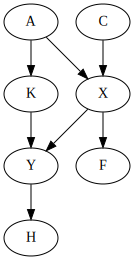

In [13]:
fd_disc = StructuralCausalModel({
    "C": lambda n_samples: np.random.binomial(n=1, p=0.7, size=n_samples),
    "A": lambda n_samples: np.random.binomial(n=1, p=0.2, size=n_samples),
    "K": lambda A, n_samples: A + .1 * np.random.normal(),
    "K": discrete_model(["A"], {
        (0, ): (0.9, 0.1),
        (1, ): (0.3, 0.7),
        }),
    "X": discrete_model(["C", "A"], {
        (0, 0): (0.1, 0.9), 
        (0, 1): (0.7, 0.3),
        (1, 0): (0.5, 0.5),
        (1, 1): (0.8, 0.2),
        }),  
    "F": discrete_model(["X"], {
        (0, ): (0.6, 0.4),
        (1, ): (0.1, 0.9),
        }),
    "Y": discrete_model(["K", "X"], {
        (0, 0): (0.9, 0.1), 
        (0, 1): (0.3, 0.7),
        (1, 0): (0.2, 0.5),
        (1, 1): (0.5, 0.5),
        }),
    "H": discrete_model(["Y"], {
        (0, ): (0.2, 0.4, 0.4),
        (1, ): (0.8, 0.1, 0.1),
        }),
})

fd_disc.cgm.draw()

In [14]:
data_disc = fd_disc.sample(n_samples = 1000000)
data_disc.head()

,C,A,K,X,F,Y,H
0,0,0,0.0,1.0,1.0,1.0,1.0
1,1,0,0.0,1.0,1.0,1.0,0.0
2,1,0,1.0,1.0,1.0,0.0,1.0
3,0,0,0.0,1.0,1.0,1.0,0.0
4,1,0,0.0,1.0,0.0,0.0,1.0


In [15]:
data_disc.describe()

,C,A,K,X,F,Y,H
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,0.699585,0.200506,0.220001,0.542105,0.671234,0.493985,0.755672
std,0.458439,0.400379,0.414247,0.498224,0.469765,0.499964,0.829968
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
75%,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


Identifying True causal effect:

In [16]:
set_variable_X = np.array([0]*500000 + [1]*500000)
ab_test_df = fd_disc.do('X').sample(
                    set_values={'X': set_variable_X}, 
                    n_samples=len(set_variable_X),
                  )
ab_test_df.head()

,C,A,X,K,F,Y,H
0,1,0,0,0.0,0.0,0.0,1.0
1,1,0,0,0.0,1.0,0.0,1.0
2,1,0,0,0.0,1.0,0.0,2.0
3,0,0,0,0.0,0.0,1.0,0.0
4,0,0,0,0.0,1.0,0.0,1.0


In [17]:
true_ate = ab_test_df[ab_test_df['X'] == 1]['Y'].mean() - ab_test_df[ab_test_df['X'] == 0]['Y'].mean()
true_ate

0.42064599999999996

Excercise 2:

1. Can we estimate causal effect for discrete model using regression? Try using the function you implemented above.
2. Test all possible adjustment sets. Are there any additional adjustments sets with correct result?

Valid backdoor adjustment sets

In [18]:
fd_disc.cgm.get_all_backdoor_adjustment_sets(x='X', y='Y')

frozenset({frozenset({'K'}),
           frozenset({'C', 'K'}),
           frozenset({'A'}),
           frozenset({'A', 'K'}),
           frozenset({'A', 'C'}),
           frozenset({'A', 'C', 'K'})})

In [19]:
adj_sets = []
for var_set in all_sets:
  if my_backdoor_adjustment_regression(data_disc, T='X', Y='Y', cond_set=var_set, true_ate = true_ate) == True:
    adj_sets.append(var_set)

Set: ['X', 'C'], X has the coefficient: 0.3725710623097595
Set: ['X', 'A'], X has the coefficient: 0.4412095527741924
Set: ['X', 'K'], X has the coefficient: 0.4256857626072575
Set: ['X', 'F'], X has the coefficient: 0.3827372569406868
Set: ['X', 'H'], X has the coefficient: 0.283807201251994
Set: ['X', 'C', 'A'], X has the coefficient: 0.435475965174195
Set: ['X', 'C', 'K'], X has the coefficient: 0.4186291770799047
Set: ['X', 'C', 'F'], X has the coefficient: 0.3714480560641562
Set: ['X', 'C', 'H'], X has the coefficient: 0.2756213912158111
Set: ['X', 'A', 'K'], X has the coefficient: 0.4413652043127856
Set: ['X', 'A', 'F'], X has the coefficient: 0.4399160247411134
Set: ['X', 'A', 'H'], X has the coefficient: 0.32888439618452586
Set: ['X', 'K', 'F'], X has the coefficient: 0.42443489389600303
Set: ['X', 'K', 'H'], X has the coefficient: 0.3194403283609248
Set: ['X', 'F', 'H'], X has the coefficient: 0.28340745048769533
Set: ['X', 'C', 'A', 'K'], X has the coefficient: 0.435646130091

In [20]:
adj_sets

[['C', 'K'], ['K', 'F'], ['C', 'K', 'F']]

Based on what we observe next, applying regression on descrete dataset captures a small subset of the adjust sets.

Excercise 3:

1. Implement backdoor adjustment for arbitrary treatment, effect and conditioning set using ATE formula.

Hint: you can use dummy variable to split your dataset according to all possible combinations of confounders.

Check if your implementation is working correctly.

2. Test all possible adjustment sets. Are there any additional adjustments sets with correct result?

In [21]:
def my_backdoor_adjustment_descrete(data=data_disc, T='X', Y='Y', cond_set = ['A', 'K'], true_ate=None):
    # add your implementation
    # conditioning set can be empty, can contain 1 or more variables.
    # conditioning set never contains T or Y
    if len(cond_set) == 0:
      X_values = data[T].unique().astype(int).tolist()
      X_values.sort()
      ATE_terms = []
      counter = 0
      for x in X_values:
          ATE_terms.append(0)
          # forumulate a query of the current of value of x to search in dataframe
          q = f'{T} == {x}'
          #print(nq)
          ## Calucate expectation of Y based on values of X
          E_Y = data.query(q)[Y].mean()
          ## Calculate E_Y conditioned on nq (query q + value of x)
          ## the condition has all values of the confounders and also the value of x
          ATE_terms[counter] += E_Y
          counter += 1;
      ## Since X (treatment) has 2 values, the following quantity would be just ATE[1] - ATE[0]
      #ATE = ATE_terms[-1] - sum(ATE_terms[:-1])  
      ATE = ATE_terms[1] - ATE_terms[0]
      # Also, if we assumed T only takes the two values in [0,1], instead of for loop we would have just written the following:
      #ATE = data[data[T] == 1][Y].mean() - data[data[T] == 0][Y].mean()
    else:
      variable_values = []
      n = len(cond_set)
      ## list of lists that inner list (i) contain all values of ith variable in cond_set
      variable_values = [data[cond_set[i]].unique().astype(int).tolist() for i in range(n)]
      ## convert every value to character
      variable_values_char = [list(map(str, variable)) for variable in variable_values]
      ## construct all possible combination of values for variables of cond_set
      combinations = list(itertools.product(*variable_values_char ))
      ## now using the combinations we construct all possible queries within the data (dataframe)
      queries = []
      for i in range(len(combinations)):
        query_string = ''
        for j in range(n):
          query_string += f'{cond_set[j]} == {combinations[i][j]} and '
          if j == n-1:
            # remove the last " and " from the string 
            queries.append(query_string[:-5])
      ## example of an element in the queries list: 'A == 0 and K == 0'      
      ATE = 0
      ## Obtain possible values of X
      X_values = data[T].unique().astype(int).tolist()
      X_values.sort()
      ATE_terms = []
      counter = 0
      for x in X_values:
        ATE_terms.append(0)
        for q in queries:
          ## Add current value of x to the query q (q is obtained from list of all possible queries, over which we are iterating)
          ## example of q: "A == 1 and K == 0"
          ## example of nq: "X == 0 and A == 1 and K == 0"
          nq = f'{T} == {x} and ' + q
          #print(nq)
          ## Probability of the event q occurring
          size = data.query(q).shape[0] / data.shape[0]
          ## Calucate expectation of Y based on the new query (nq) that adds current values of x to the query
          E_Y = data.query(nq)[Y].mean()
          ## Calculate E_Y conditioned on nq (query q + value of x)
          ## the condition has all values of the confounders and also the value of x
          ATE_terms[counter] += size * E_Y
        counter += 1;
      ## Since X (treatment) has 2 values, the following quantity would be just ATE[1] - ATE[0]
      #ATE = ATE_terms[-1] - sum(ATE_terms[:-1])  
      ATE = ATE_terms[1] - ATE_terms[0]
    print(f"ATE for set {cond_set}: {ATE}")
    if math.isclose(ATE, true_ate, rel_tol=1e-2) == True:
      return True
    else:
      return False    

An example of the function above with printing of `nq`, which is all queries possible:



```
my_backdoor_adjustment_descrete(data=data_disc, T='X', Y='Y', cond_set = ['A', 'K','C'], true_ate=true_ate)

X == 0 and A == 0 and K == 0 and C == 1
X == 0 and A == 0 and K == 0 and C == 0
X == 0 and A == 0 and K == 1 and C == 1
X == 0 and A == 0 and K == 1 and C == 0
X == 0 and A == 1 and K == 0 and C == 1
X == 0 and A == 1 and K == 0 and C == 0
X == 0 and A == 1 and K == 1 and C == 1
X == 0 and A == 1 and K == 1 and C == 0
X == 1 and A == 0 and K == 0 and C == 1
X == 1 and A == 0 and K == 0 and C == 0
X == 1 and A == 0 and K == 1 and C == 1
X == 1 and A == 0 and K == 1 and C == 0
X == 1 and A == 1 and K == 0 and C == 1
X == 1 and A == 1 and K == 0 and C == 0
X == 1 and A == 1 and K == 1 and C == 1
X == 1 and A == 1 and K == 1 and C == 0
ATE for set ['A', 'K', 'C']: 0.4205944422454969
True
```




Examples but without printing queries

In [22]:
my_backdoor_adjustment_descrete(data=data_disc, T='X', Y='Y', cond_set = ['A', 'K','C'], true_ate=true_ate)

ATE for set ['A', 'K', 'C']: 0.4218549803035245


True

In [23]:
my_backdoor_adjustment_descrete(data=data_disc, T='X', Y='Y', cond_set=[], true_ate=true_ate)

ATE for set []: 0.38388731567331846


False

In [29]:
data_disc[data_disc['X'] == 1]['Y'].mean() - data_disc[data_disc['X'] == 0]['Y'].mean()

0.38388731567331846

Now we find all the adjustment sets using the `my_backdoor_adjustment_descrete` function:



In [24]:
true_ate

0.42064599999999996

In [25]:
adj_sets = []
for var_set in all_sets:
  if my_backdoor_adjustment_descrete(data_disc, T='X', Y='Y', cond_set=var_set, true_ate = true_ate) == True:
    adj_sets.append(var_set)

ATE for set ['C']: 0.36342291792900183
ATE for set ['A']: 0.4208724270325391
ATE for set ['K']: 0.4207081186411246
ATE for set ['F']: 0.3827911683067171
ATE for set ['H']: 0.26066037660644054
ATE for set ['C', 'A']: 0.42143009870542125
ATE for set ['C', 'K']: 0.42095007252171046
ATE for set ['C', 'F']: 0.36236723251095304
ATE for set ['C', 'H']: 0.2456566516113552
ATE for set ['A', 'K']: 0.42116044996089014
ATE for set ['A', 'F']: 0.41963237367699807
ATE for set ['A', 'H']: 0.30728121785735846
ATE for set ['K', 'F']: 0.41972546303415315
ATE for set ['K', 'H']: 0.3294857448719179
ATE for set ['F', 'H']: 0.2606050615206216
ATE for set ['C', 'A', 'K']: 0.4218549803035246
ATE for set ['C', 'A', 'F']: 0.41944885454169534
ATE for set ['C', 'A', 'H']: 0.3081864300804882
ATE for set ['C', 'K', 'F']: 0.42010607902344715
ATE for set ['C', 'K', 'H']: 0.3298487454338329
ATE for set ['C', 'F', 'H']: 0.24607313522042856
ATE for set ['A', 'K', 'F']: 0.42040845153314854
ATE for set ['A', 'K', 'H']: 0.

In [26]:
adj_sets

[['A'],
 ['K'],
 ['C', 'A'],
 ['C', 'K'],
 ['A', 'K'],
 ['A', 'F'],
 ['K', 'F'],
 ['C', 'A', 'K'],
 ['C', 'A', 'F'],
 ['C', 'K', 'F'],
 ['A', 'K', 'F'],
 ['C', 'A', 'K', 'F']]

The difference between the function I wrote and the built-in function `fd_disc.cgm.get_all_backdoor_adjustment_sets`, is that my function adds variable F to the combinations of adjust sets as well.

